In [4]:
# -*- coding: utf-8 -*-
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import cv2 as cv
from PIL import Image
import load_data
from load_data import ForamDataSet
from importlib import reload

plt.ion()   # interactive mode
train_on_gpu = torch.cuda.is_available()
reload(load_data)


<module 'load_data' from '/home/camelcars/Documents/ucl2/systemsEng/software_FT/projectsite/common/load_data.py'>

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # val does not use augmentation
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # test does not use augmentation
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [69]:
data_dir = '../media'
image_datasets = {}
image_datasets['train'] = ForamDataSet(csv_file='../train.csv',
                                       root_dir='../media',
                                       transform=data_transforms['train'])
image_datasets['val'] = ForamDataSet(csv_file='../val.csv',
                                     root_dir='../media',
                                     transform=data_transforms['val'])
image_datasets['test'] = ForamDataSet(csv_file='../test.csv',
                                     root_dir='../media',
                                     transform=data_transforms['test'])                                     
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
# class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

17
17
17


In [79]:
def visualize_frequency(path='../all.csv'):
    df = pd.read_csv(path)
    df = df.groupby('species').count()
    arr = [tuple((x)) for x in df.to_records()]
    arr = sorted(arr, key=lambda x:x[1], reverse=True)
    species = [str(i[0]) for i in arr]
    frequency = [int(i[1]) for i in arr]
    
    y_pos = np.arange(len(species))
    plt.bar(y_pos, frequency, align='center', alpha=0.5)
    plt.xticks(y_pos, species)
    plt.xticks(rotation=80)
    plt.ylabel('Frequency')
    plt.title('Species')

    plt.show()

csv_file = pd.read_csv('../all.csv')


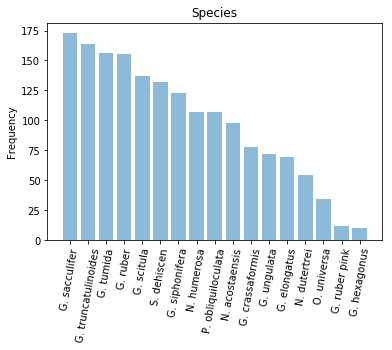

In [80]:
visualize_frequency()

In [78]:
train = image_datasets['train']
val = image_datasets['val']
test = image_datasets['test']
assert(train.labels == val.labels == test.labels)

In [120]:
def visualize_categories():
    train_csv = pd.read_csv('../train.csv').groupby('species').count()
    val_csv = pd.read_csv('../val.csv').groupby('species').count()
    test_csv = pd.read_csv('../test.csv').groupby('species').count()
    merged_csv = pd.merge(pd.merge(train_csv, val_csv, on='species'), test_csv, on='species')
    merged_csv.columns = ['n_train', 'n_val', 'n_test']
    print(merged_csv.sort_values(by=['n_train'], ascending=False))
visualize_categories()

                     n_train  n_val  n_test
species                                    
G. sacculifer             96     39      38
G. ruber                  91     29      35
G. tumida                 89     32      35
G. truncatulinoides       83     38      43
G. scitula                63     44      30
G. siphonifera            58     30      35
S. dehiscen               58     38      36
N. humerosa               55     27      25
N. acostaensis            49     28      21
P. obliquiloculata        43     29      35
G. ungulata               38     15      19
G. elongatus              31     17      21
G. crassaformis           30     22      26
N. dutertrei              24     16      14
O. universa               21      8       5
G. ruber pink              4      5       3


In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [31]:
######################################################################
# Training the model
# ------------------
#
# Now, let's write a general function to train a model. Here, we will
# illustrate:
#
# -  Scheduling the learning rate
# -  Saving the best model
#
# In the following, parameter ``scheduler`` is an LR scheduler object from
# ``torch.optim.lr_scheduler``.


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # print(outputs)
                    loss = criterion(outputs, labels)
                    # print('loss:', loss)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), './resnet18-foram.pth')
    return model

In [32]:
# Generic function to display predictions for a few images

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

######################################################################
# Finetuning the convnet
# ----------------------
#
# Load a pretrained model and reset final fully connected layer.
#

model_ft = models.resnet18(pretrained=True)
# model_ft = models.vgg16(pretrained=True)
num_ftrs = model_ft.fc.in_features
print('num_ftrs:', num_ftrs)
print('parameters', model_ft.parameters)
model_ft.fc = nn.Linear(num_ftrs, 17)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# It should take around 15-25 min on CPU. On GPU though, it takes less than a
# minute.

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

# visualize_model(model_ft)

num_ftrs: 512
parameters <bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [43]:
summary(model_ft, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [44]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [68]:
model_ft.idx_to_class = {num:species for num,species in enumerate(image_datasets['train'].labels)}

In [19]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint
    This is better than the default save as you save more info

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """
    print(path.split('-'))
    model_name = os.path.basename(path).split('-')[0]
    print(model_name)
    assert (model_name in ['vgg16', 'resnet50', 'resnet18'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet18':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [6]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """
    model = models.resnet18(pretrained=True)
    # Changing the output of the final layer
    model.fc = nn.Linear(model.fc.in_features, 17)
    model.load_state_dict(torch.load(path))
    model.idx_to_class = {num:species for num,species in enumerate(image_datasets['train'].labels)}    
#     for param in model.parameters():
#             param.requires_grad = False
#     if model_name == 'vgg16':
#         model = models.vgg16(pretrained=True)
#         # Make sure to set parameters as not trainable
#         for param in model.parameters():
#             param.requires_grad = False
#         model.classifier = checkpoint['classifier']

#     elif model_name == 'resnet18':
#         model = models.resnet50(pretrained=True)
#         # Make sure to set parameters as not trainable
#         for param in model.parameters():
#             param.requires_grad = False
# #         model.fc = checkpoint['fc']

#     # Load in the state dict
#     model.load_state_dict(checkpoint['state_dict'])

#     total_params = sum(p.numel() for p in model.parameters())
#     print(f'{total_params:,} total parameters.')
#     total_trainable_params = sum(
#         p.numel() for p in model.parameters() if p.requires_grad)
#     print(f'{total_trainable_params:,} total gradient parameters.')

#     # Move to gpu
#     if multi_gpu:
#         model = nn.DataParallel(model)

#     if train_on_gpu:
#         model = model.to('cuda')

#     # Model basics
#     model.class_to_idx = checkpoint['class_to_idx']
#     model.idx_to_class = checkpoint['idx_to_class']
#     model.epochs = checkpoint['epochs']

#     # Optimizer
#     optimizer = checkpoint['optimizer']
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model

In [20]:
save_checkpoint(model_ft, './resnet18-foram.pth')

['./resnet18', 'foram.pth']
resnet18


AttributeError: 'ResNet' object has no attribute 'class_to_idx'

In [45]:
torch.save(model_ft.state_dict(), './resnet18-foram.pth')

In [7]:
model_ft.load_state_dict(torch.load('./resnet18-foram.pth'))

NameError: name 'model_ft' is not defined

In [10]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [19]:
def imshow_tensor(image, ax=None, title=None):
    """
    Imshow for Tensor.
    Basicaly reverses the image to tensor process
    """

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

In [18]:
img = process_image('../media/G. ruber/0c2434995cae47c392a409114d017e7f.tif')
img.shape

torch.Size([3, 224, 224])

In [72]:
def predict(model, image_path, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

In [8]:
model = load_checkpoint('./resnet18-foram.pth')

In [76]:
predict(model, '../media/G. ruber/0c2434995cae47c392a409114d017e7f.tif')

(tensor([[[-1.6915, -1.6915, -1.6232,  ..., -1.7767, -1.7767, -1.7767],
          [-1.6915, -1.6915, -1.6232,  ..., -1.7767, -1.7767, -1.7767],
          [-1.6744, -1.6744, -1.6403,  ..., -1.7767, -1.7767, -1.7767],
          ...,
          [-1.5721, -1.5721, -1.7256,  ..., -1.8109, -1.7256, -1.7256],
          [-1.6573, -1.6573, -1.8109,  ..., -1.7597, -1.6915, -1.6915],
          [-1.6573, -1.6573, -1.8109,  ..., -1.7597, -1.6915, -1.6915]],
 
         [[-1.6172, -1.6172, -1.5823,  ..., -1.6695, -1.6869, -1.6869],
          [-1.6172, -1.6172, -1.5823,  ..., -1.6695, -1.6869, -1.6869],
          [-1.5300, -1.5300, -1.5823,  ..., -1.6869, -1.6869, -1.6869],
          ...,
          [-1.3730, -1.3730, -1.5300,  ..., -1.6346, -1.6346, -1.6346],
          [-1.5126, -1.5126, -1.6346,  ..., -1.5823, -1.5997, -1.5997],
          [-1.5126, -1.5126, -1.6346,  ..., -1.5823, -1.5997, -1.5997]],
 
         [[-1.2836, -1.2836, -1.2489,  ..., -1.4225, -1.4051, -1.4051],
          [-1.2836, -1.2836,

In [60]:
def accuracy(output, target, topk=(1, )):
    """
    Compute the topk accuracy(s)
    target: the correct answer
    """
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()
#         print(pred)
        # Determine predictions equal to the targets
#         print(target.view(1,-1).expand_as(pred))
        correct = pred.eq(target.view(1, -1).expand_as(pred))
#         print(correct)
        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
#             print(correct_k)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [43]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

In [57]:
if train_on_gpu:
    accuracy(model(features.to('cuda')), targets, topk=(1, 5))
else:
    print(accuracy(model(features), targets, topk=(1, 5)))
print(targets)

tensor([[ 1,  8, 10,  5],
        [ 5, 13,  0,  8],
        [ 3,  7,  6,  7],
        [10,  3,  9,  1],
        [15,  5,  7, 13]])
tensor([[ 1,  8, 10,  7],
        [ 1,  8, 10,  7],
        [ 1,  8, 10,  7],
        [ 1,  8, 10,  7],
        [ 1,  8, 10,  7]])
tensor([[1, 1, 1, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=torch.uint8)
[75.0, 100.0]
tensor([ 1,  8, 10,  7])


In [44]:
print(accuracy(model(features), targets))


[75.0]


In [64]:
def evaluate_for_categories(model, test_loader, criterion, topk=(1, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """

    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, 17), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    for i in topk:
        print(i)
    results = pd.DataFrame(acc_results, columns=['top{i}'.format(i=i) for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'})

In [70]:
criterion = nn.CrossEntropyLoss()
# Evaluate the model on all the training data
results = evaluate_for_categories(model, dataloaders['test'], criterion)

1
5


In [71]:
print(results)

                  class        top1        top5      loss
0       G. crassaformis   34.615385   92.307692  2.093007
1          G. elongatus   85.714286  100.000000  0.384988
2              G. ruber   85.714286   97.142857  0.627504
3         G. ruber pink   66.666667  100.000000  1.030158
4         G. sacculifer   92.105263  100.000000  0.197761
5            G. scitula   73.333333   83.333333  1.901729
6        G. siphonifera   82.857143  100.000000  0.571984
7   G. truncatulinoides   93.023256   95.348837  0.381241
8             G. tumida  100.000000  100.000000  0.042303
9           G. ungulata   84.210526  100.000000  0.723908
10       N. acostaensis   80.952381  100.000000  0.433141
11         N. dutertrei   85.714286   92.857143  0.683870
12          N. humerosa   84.000000   96.000000  0.636962
13          O. universa   20.000000  100.000000  3.739821
14   P. obliquiloculata   77.142857   91.428571  0.724691
15          S. dehiscen   88.888889  100.000000  0.300313


In [124]:
def evaluate_all(model, test_loader, criterion):
    model.eval()
    with torch.no_grad():
        counter = 0
        result = 0
        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            print(accuracy(model(data), targets)[0])
            result += accuracy(model(features), targets)[0]
            counter += 1
    print(counter)
    return result/counter

In [73]:
# Evaluate the model on all the training data
results = evaluate_all(model, dataloaders['test'], criterion)

75.0
100.0
50.0
100.0
100.0
100.0
100.0
100.0
75.0
100.0
100.0
100.0
75.0
100.0
75.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
75.0
100.0
100.0
75.0
100.0
75.0
75.0
75.0
75.0
25.0
75.0
100.0
50.0
75.0
75.0
50.0
100.0
25.0
75.0
75.0
75.0
100.0
75.0
100.0
100.0
100.0
50.0
100.0
75.0
100.0
100.0
100.0
100.0
100.0
50.0
75.0
50.0
100.0
75.0
75.0
75.0
100.0
75.0
75.0
100.0
75.0
100.0
50.0
75.0
75.0
100.0
100.0
75.0
100.0
75.0
50.0
100.0
100.0
100.0
50.0
100.0
100.0
75.0
50.0
75.0
100.0
75.0
50.0
75.0
100.0
75.0
50.0
75.0
100.0
75.0
100.0
75.0
50.0
25.0
75.0
100.0
100.0
50.0
100.0


In [123]:
print(results)
print(len(pd.read_csv('../test.csv')))

7.783018867924528
421
